# pPXF: Fitting integral-field data

Usage example for the procedure pPXF originally described in [Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C), substantially upgraded in [Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C) and with the inclusion of photometry and linear constraints in [Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C).

* V1.0.0: Michele Cappellari, Oxford, 29 March 2022
* V1.1.0: MC, Oxford, 28 November 2023: Updated for pPXF 9.0 using the new `sps_util`.

![pPXF Logo](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.svg)

In [98]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from os import path
from urllib import request

from ppxf.ppxf import ppxf, robust_sigma
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins

## Function to read the MUSE cube

In [99]:
class read_muse_cube(object):
    def __init__(self, wave_range):
        """
        Read MUSE cube, log rebin it and compute coordinates of each spaxel.
        Median FWHM resolution = 2.62Å. Range: 2.51--2.88 (ESO instrument manual)
        
        """
        filename = 'LVS_JWST_workshop_rodeo_cube.fits'  # NGC1386
        hdu = fits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data   # cube.shape = (3681, nx, ny)

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1) # create array of spectra [npix, nx*ny]
        wave = head['CRVAL3'] + head['CDELT3']*np.arange(npix)
        pixsize = abs(head["CDELT1"])*3600    # 0.2"

        # Only use a restricted wavelength range
        w = (wave > wave_range[0]) & (wave < wave_range[1])
        spectra = spectra[w, :]
        wave = wave[w]

        # Create coordinates centred on the brightest spectrum
        flux = np.nanmean(spectra, 0)
        jm = np.argmax(flux)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*pixsize
        y = (row - row[jm])*pixsize
        c = 299792.458  # speed of light in km/s
        velscale = c*np.diff(np.log(wave[-2:]))  # Smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)
        
        self.spectra = spectra
        self.x = x
        self.y = y
        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.flux = flux
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = 2.62  # Median FWHM resolution of MUSE

## Function to iteratively clip the outliers

In [100]:
def clip_outliers(galaxy, bestfit, goodpixels):
    """
    Repeat the fit after clipping bins deviants more than 3*sigma
    in relative error until the bad bins don't change any more.
    """
    while True:
        scale = galaxy[goodpixels] @ bestfit[goodpixels]/np.sum(bestfit[goodpixels]**2)
        resid = scale*bestfit[goodpixels] - galaxy[goodpixels]
        err = robust_sigma(resid, zero=1)
        ok_old = goodpixels
        goodpixels = np.flatnonzero(np.abs(bestfit - galaxy) < 3*err)
        if np.array_equal(goodpixels, ok_old):
            break
            
    return goodpixels

## Function to fit the stellar kinematics

The following function fits the spectrum with `pPXF` while masking the gas emission lines, then iteratively clips the outliers and finally refit the spectrum with `pPXF` on the cleaned spectrum.

In [101]:
def fit_and_clean(templates, galaxy, velscale, start, goodpixels0, lam, lam_temp):
    
    print('##############################################################')
    goodpixels = goodpixels0.copy()
    pp = ppxf(templates, galaxy, np.ones_like(galaxy), velscale, start,
              moments=2, degree=-1, mdegree=4, lam=lam, lam_temp=lam_temp,
              goodpixels=goodpixels)

    plt.figure(figsize=(20, 3))
    plt.subplot(121)
    pp.plot()

    goodpixels = clip_outliers(galaxy, pp.bestfit, goodpixels)

    # Add clipped pixels to the original masked emission lines regions and repeat the fit
    goodpixels = np.intersect1d(goodpixels, goodpixels0)
    pp = ppxf(templates, galaxy, np.ones_like(galaxy), velscale, start,
              moments=2, degree=-1, mdegree=4, lam=lam, lam_temp=lam_temp,
              goodpixels=goodpixels)
    
    plt.subplot(122)
    pp.plot()


    optimal_template = templates @ pp.weights
    
    return pp, optimal_template

## Read the data cube and Voronoi bin the data

I only extract the cube over the wavelength region where there are emission lines and where the spectrum is less contaminated by sky residuals.

In [102]:
lam_range_temp = [3540, 7409]   # Focus on optical region
s = read_muse_cube(lam_range_temp)

In this example I request an excessively large `target_sn=350` to speed up the calculation. This generates only 9 Voronoi bins. But in a real situation the spatially binned data cube will contain over a hundred Voronoi bins e.g. with `target_sn=60`.

In [103]:
signal = np.median(s.spectra, 0)
noise = np.sqrt(signal)
target_sn = 350
# target_sn = 60

Perform Voronoi binning with the method of [Cappellari & Copin (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.342..345C)

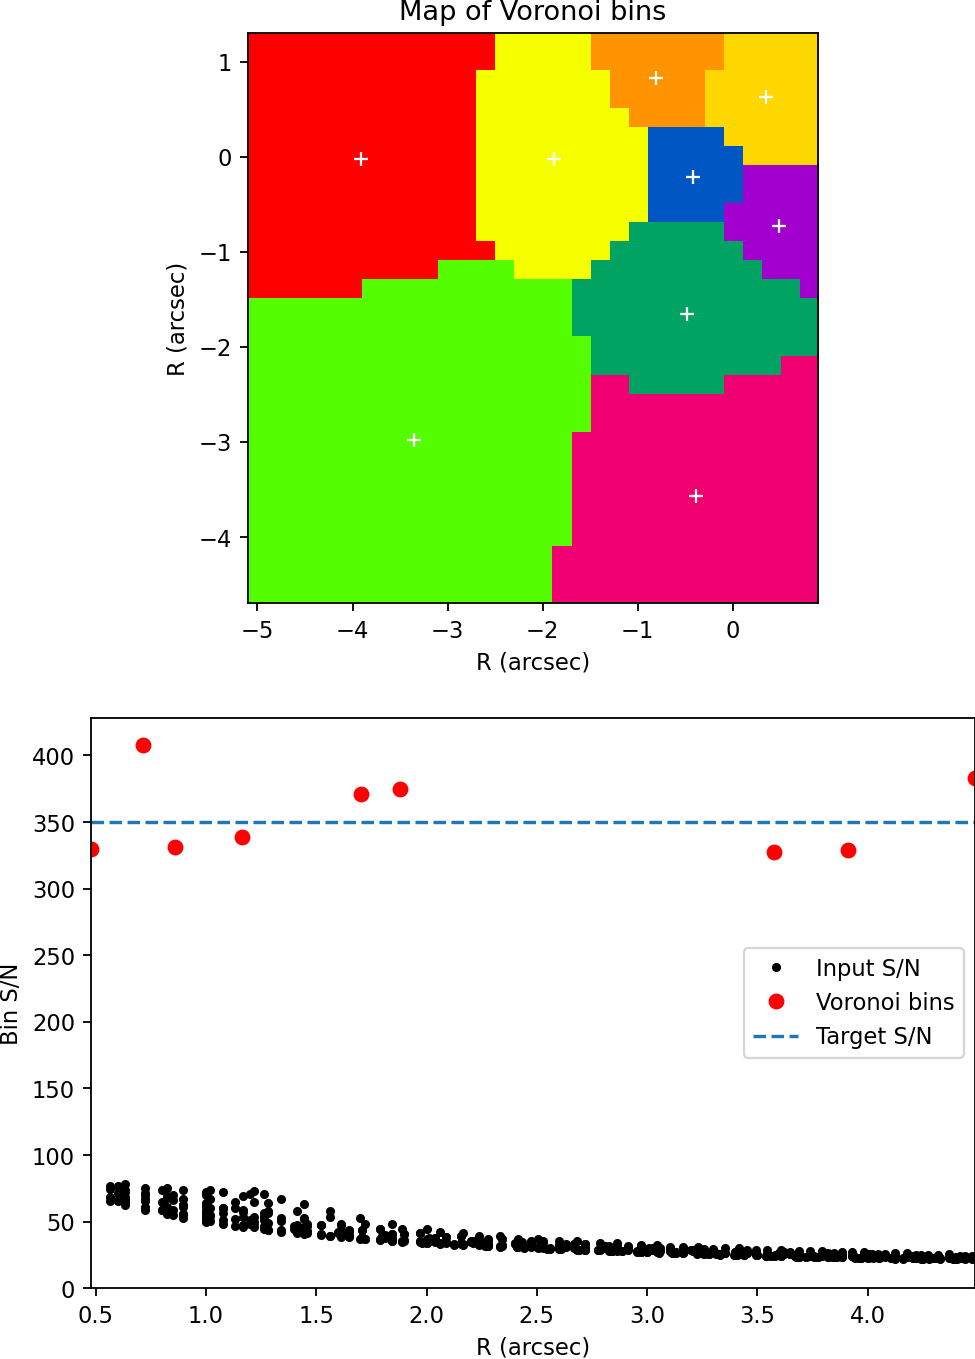

In [104]:
plt.figure(figsize=(7,10))
bin_num, x_gen, y_gen, xbin, ybin, sn, nPixels, scale = voronoi_2d_binning(s.x, s.y, signal, noise, target_sn, plot=1, quiet=1)

Here is the result of this Notebook when using a proper Voronoi binning with `target_sn=60`
<br>
![](binning.png)

## Setup stellar templates

The important formula below **defines** the relation between velocity, wavelength and redshift in ``pPXF`` (eq. 8 of [Cappellari 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.466..798C))


$$V\equiv c\Delta\ln\lambda = c\ln(1+z)$$

In [105]:

c_kms = 299792.458  # speed of light in km/s
velscale = c_kms*np.diff(s.ln_lam_gal[:2])   # eq.(8) of Cappellari (2017)
velscale = velscale[0]   # must be a scalar

pPXF can be used with any set of SPS population templates. However, I am currently providing (with permission) ready-to-use template files for three SPS. One can just uncomment one of the three models below. The included files are only a subset of the SPS that can be produced with the models, and one should use the relevant software to produce different sets of SPS templates if needed.

1. If you use the [fsps v3.2](https://github.com/cconroy20/fsps) SPS model templates, please also cite [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...699..486C) and [Conroy et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010ApJ...712..833C) in your paper.

2. If you use the [GALAXEV v2000](http://www.bruzual.org/bc03/) SPS model templates, please also cite [Bruzual & Charlot (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.344.1000B) in your paper.

3. If you use the [E-MILES](http://miles.iac.es/) SPS model templates, please also cite [Vazdekis et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.463.3409V) in your paper. 
<font color='red'>WARNING: the E-MILES models do not include very young SPS and should not be used for highly star forming galaxies.</font>  

In [106]:
# sps_name = 'fsps'
# sps_name = 'galaxev'
sps_name = 'emiles'

Read SPS models file from my GitHub if not already in the pPXF package dir. I am not distributing the templates with pPXF anymore.
The SPS model files are also available [this GitHub page](https://github.com/micappe/ppxf_data).

In [107]:
ppxf_dir = path.dirname(path.realpath(lib.__file__))
basename = f"spectra_{sps_name}_9.0.npz"
filename = path.join(ppxf_dir, 'sps_models', basename)
if not path.isfile(filename):
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

In [108]:
FWHM_gal = None   # set this to None to skip convolution
sps = lib.sps_lib(filename, velscale, FWHM_gal, norm_range=[5070, 5950])
stars_templates, ln_lam_temp = sps.templates, sps.ln_lam_temp

The stellar templates are reshaped into a 2-dim array with each spectrum as a column, however we save the original array dimensions, which are needed to specify the regularization dimensions


In [109]:
reg_dim = stars_templates.shape[1:]
stars_templates = stars_templates.reshape(stars_templates.shape[0], -1)

See the pPXF documentation for the keyword REGUL, for an explanation of the following two lines.


In [110]:
stars_templates /= np.median(stars_templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

In [111]:
z = 0.002895  # redshift estimate from NED
vel0 = c_kms*np.log(1 + z)  # Initial estimate of the galaxy velocity in km/s. eq. (8) of Cappellari (2017)
start = [vel0, 200.]  # (km/s), starting guess for [V,sigma]

In [112]:
lam_range_temp = np.exp(ln_lam_temp[[0, -1]])
goodpixels0 = util.determine_goodpixels(s.ln_lam_gal, lam_range_temp, z, width=1000)

## Fit templates and stellar kinematics in Voronoi binned data

In [113]:
nbins = sn.size
velbin, sigbin, lg_age_bin, metalbin, nspax = np.zeros((5, nbins))
optimal_templates = np.empty((stars_templates.shape[0], nbins))

##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       855       108
chi2/DOF: 1.238e+07; DOF: 2347; degree = -1; mdegree = 4
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 4/150
 Best Fit:       Vel     sigma
 comp.  0:       854       112
chi2/DOF: 2.591e+06; DOF: 2192; degree = -1; mdegree = 4
method = capfit; Jac calls: 6; Func calls: 46; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 3/150
Weighted <lg_age> [yr]: 9.34
Weighted <[M/H]>: -0.136
Voronoi bin: 1 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       929       108
chi2/DOF: 5.324e+06; DOF: 2347; degree = -1; mdegree = 4
method = capfit; Jac calls: 7; Func calls: 52; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150
 Best Fit:       Vel     sigma
 comp.  0:       935       112
chi2/DOF: 1.595e+06; DOF: 2260; degre

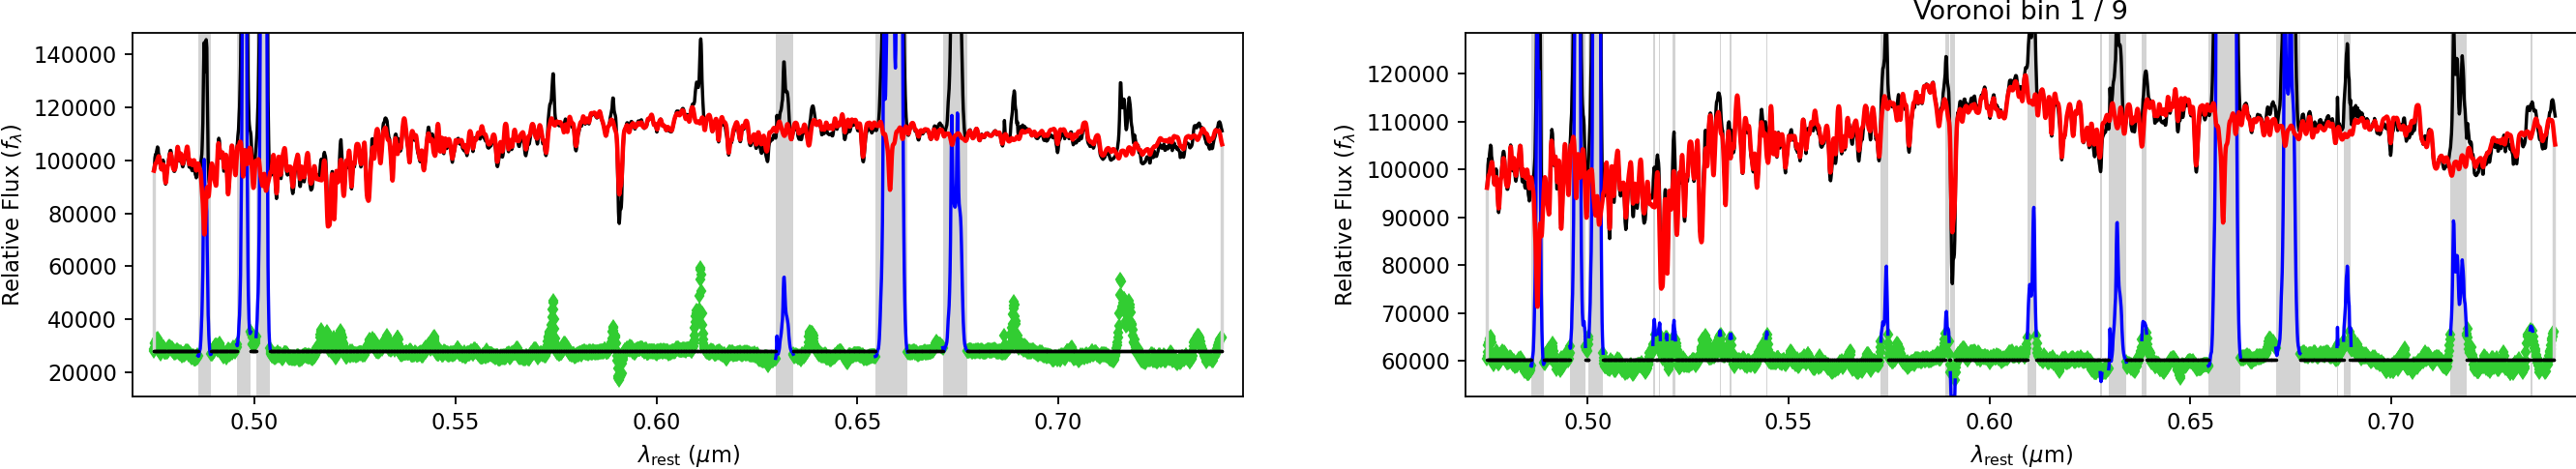

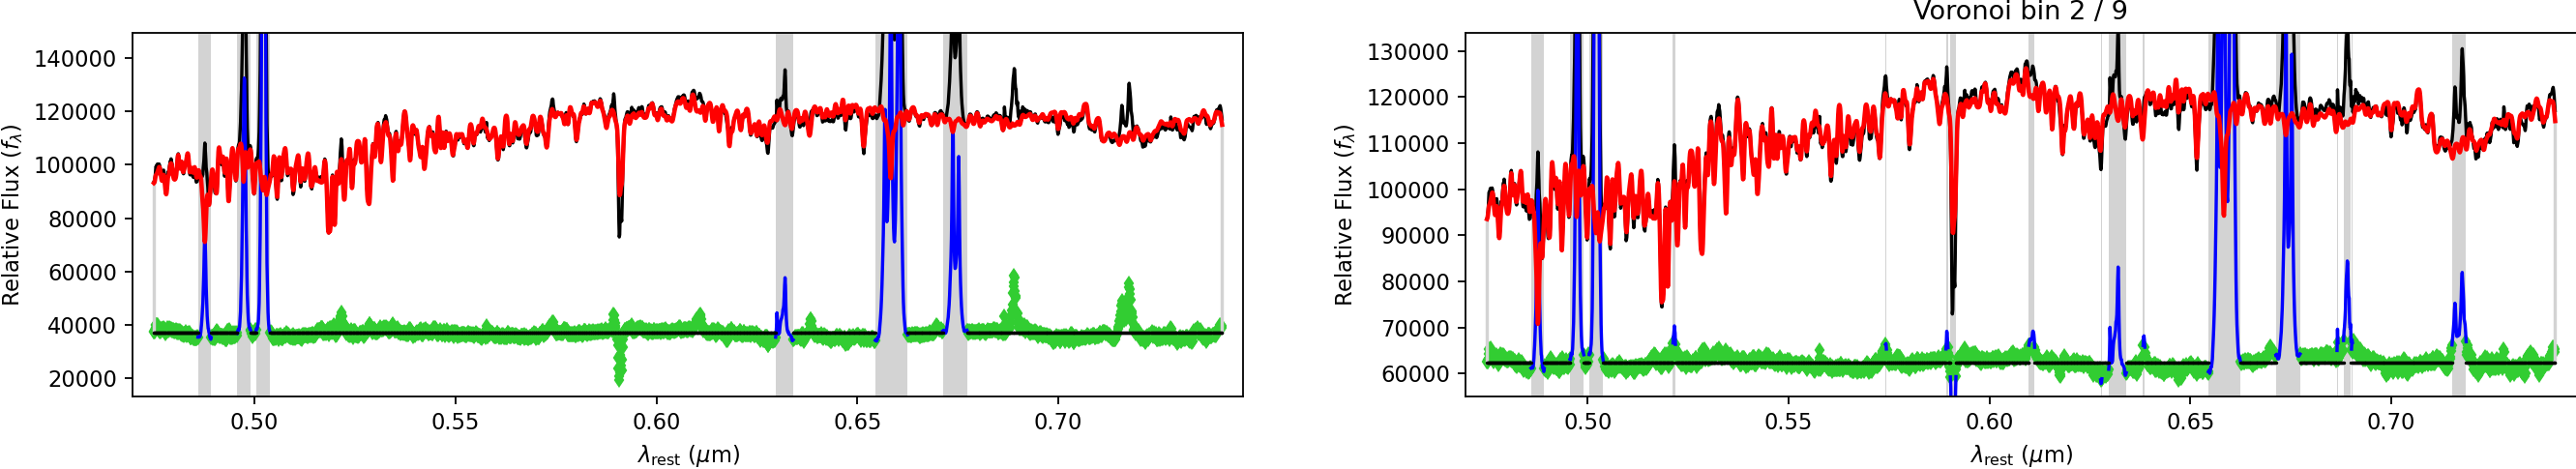

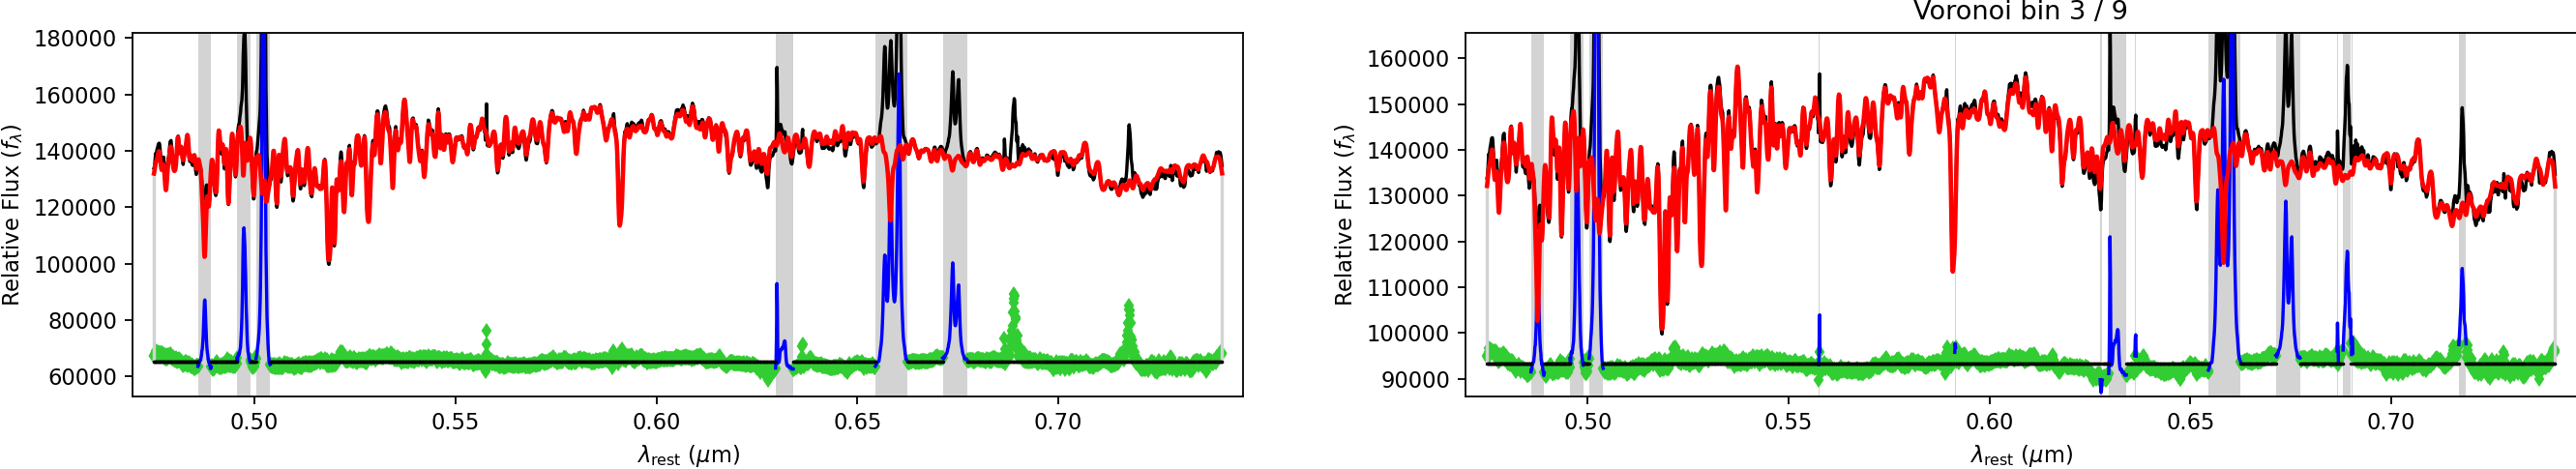

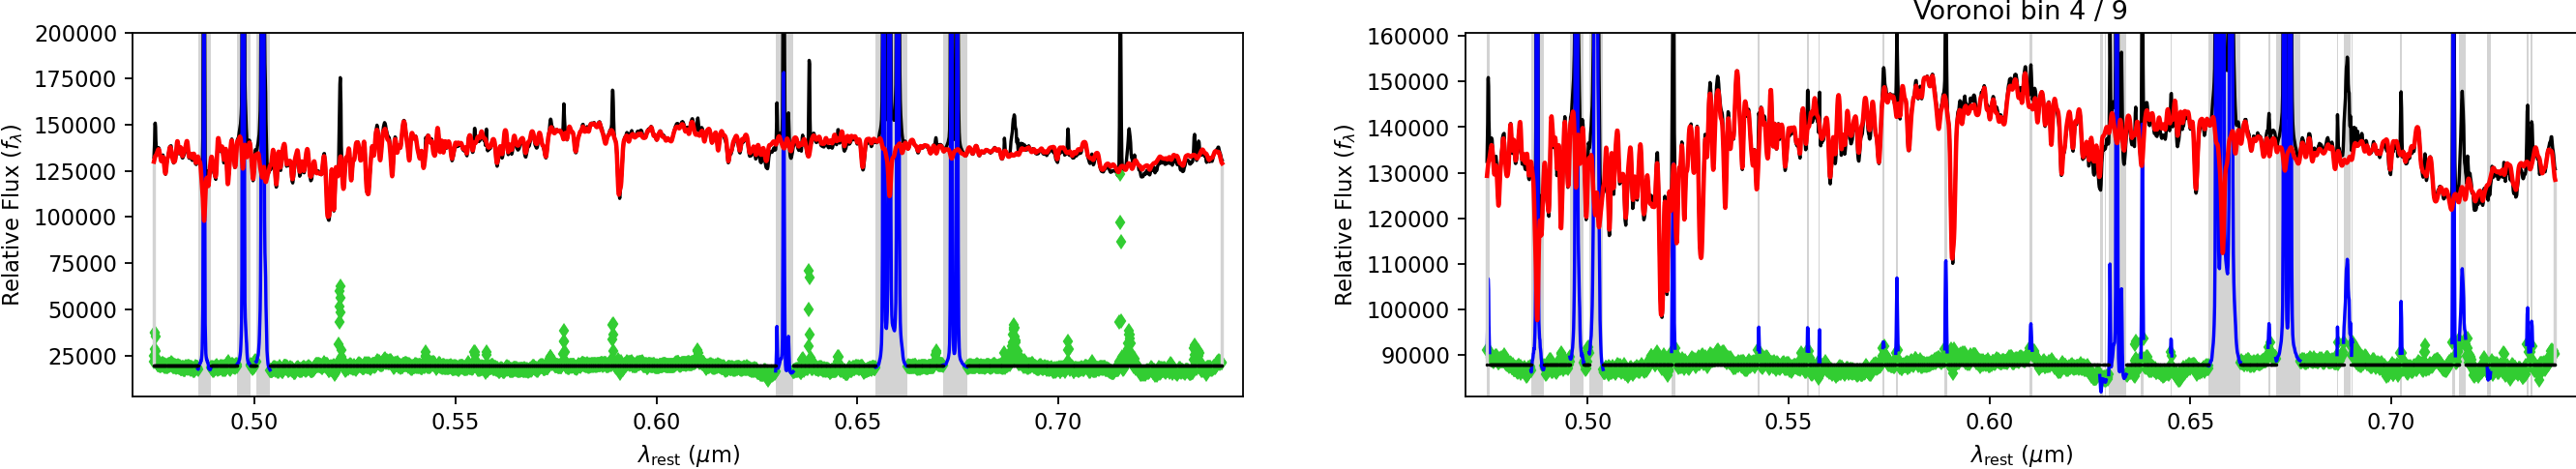

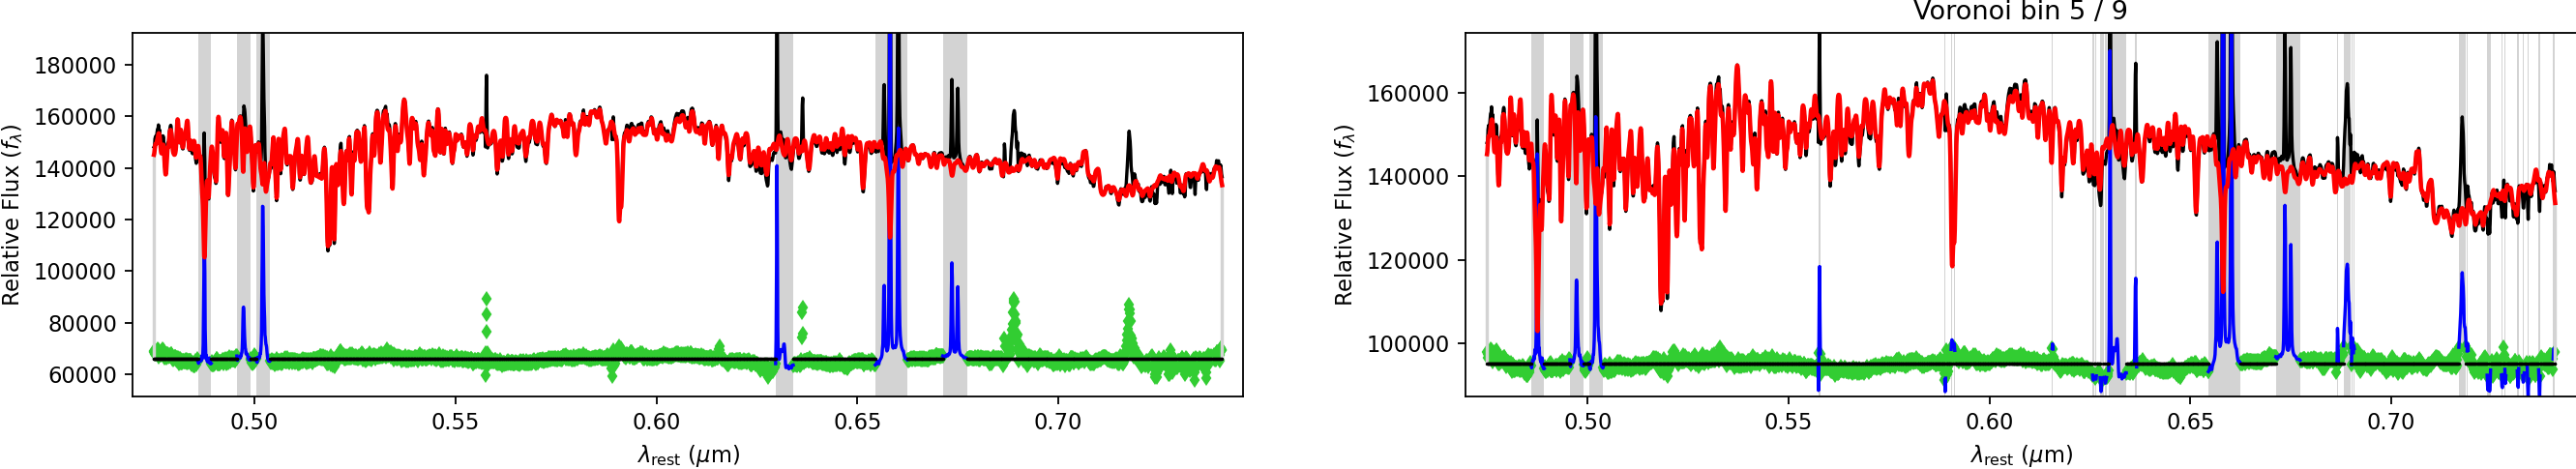

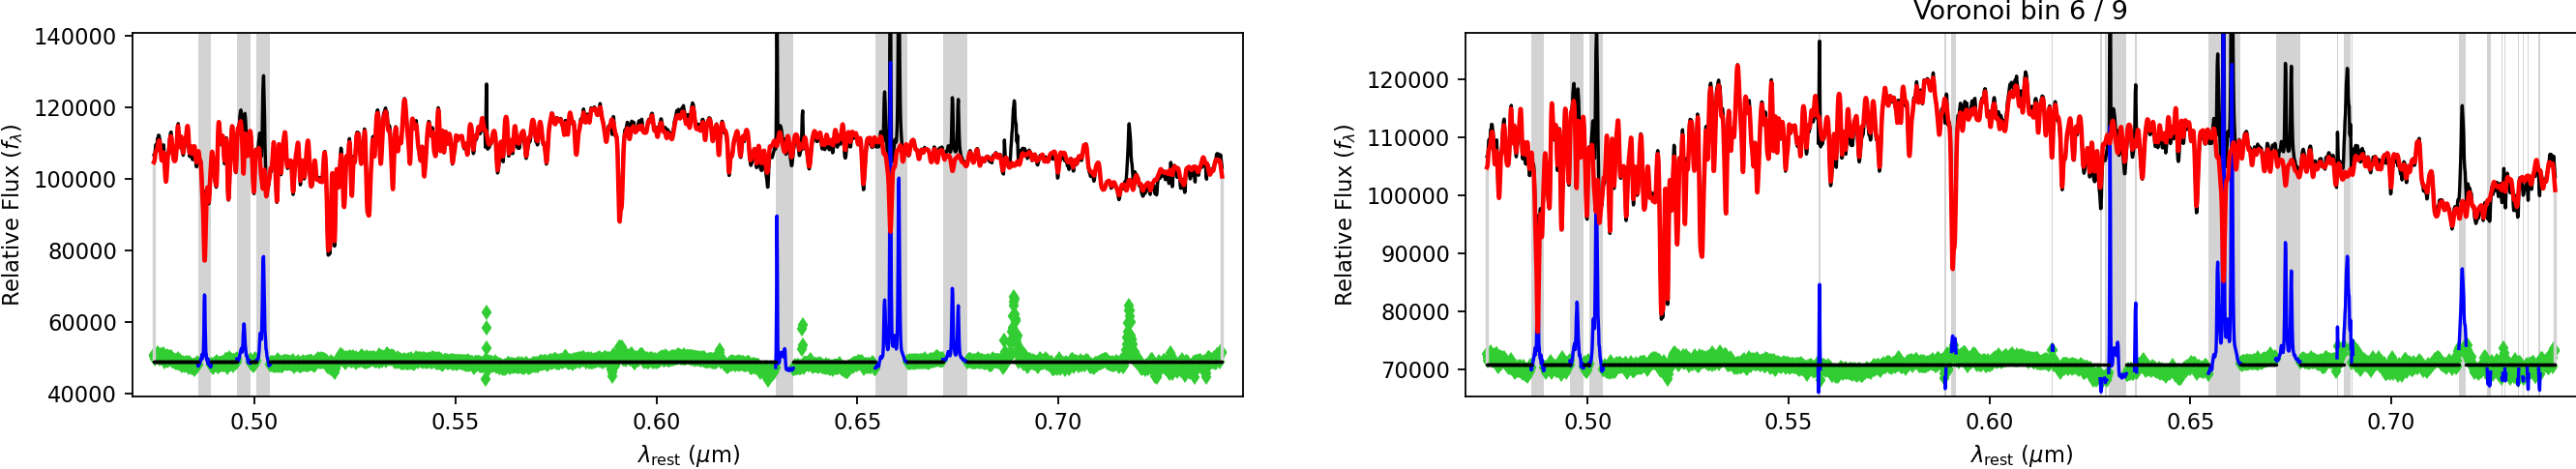

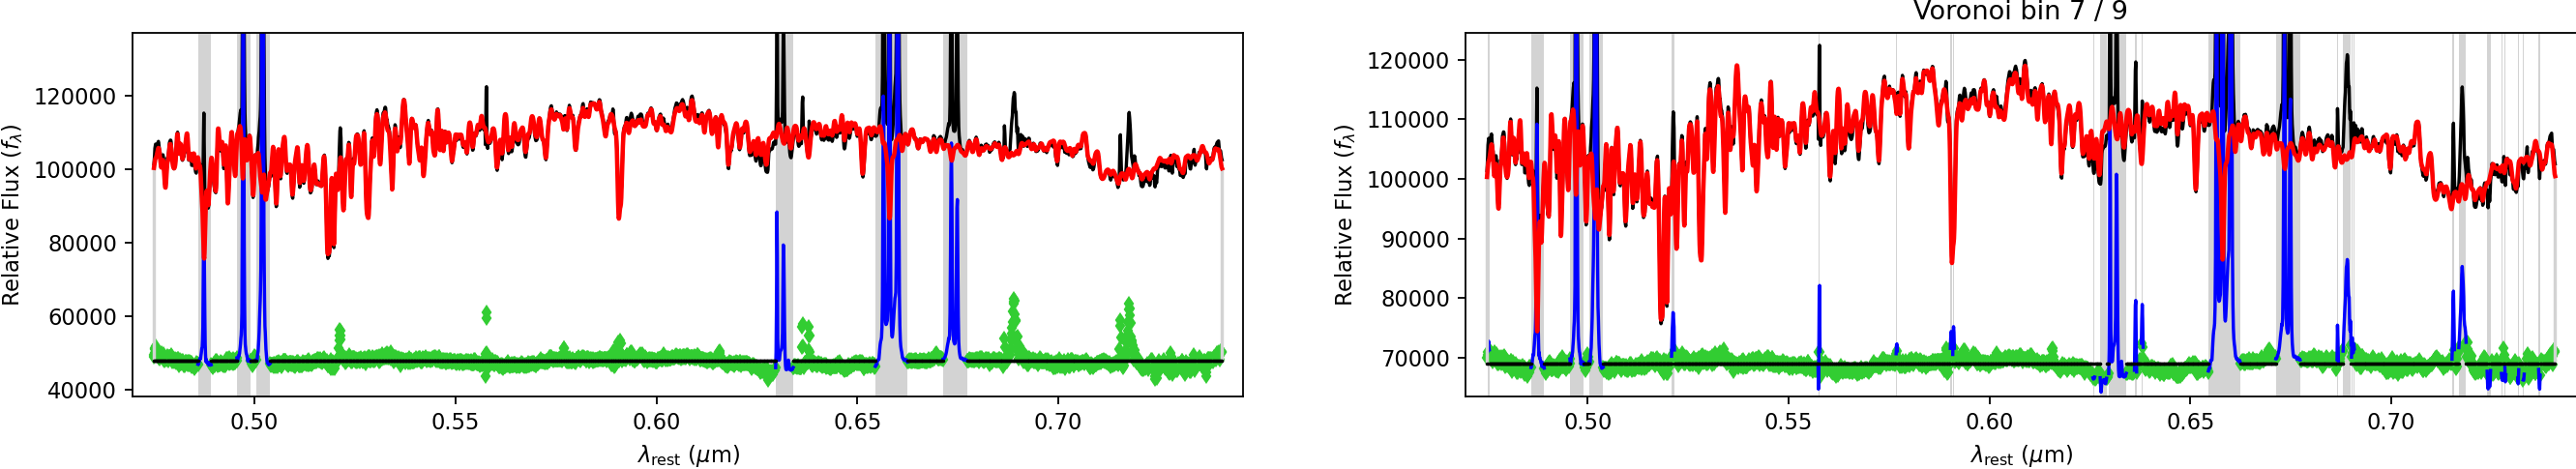

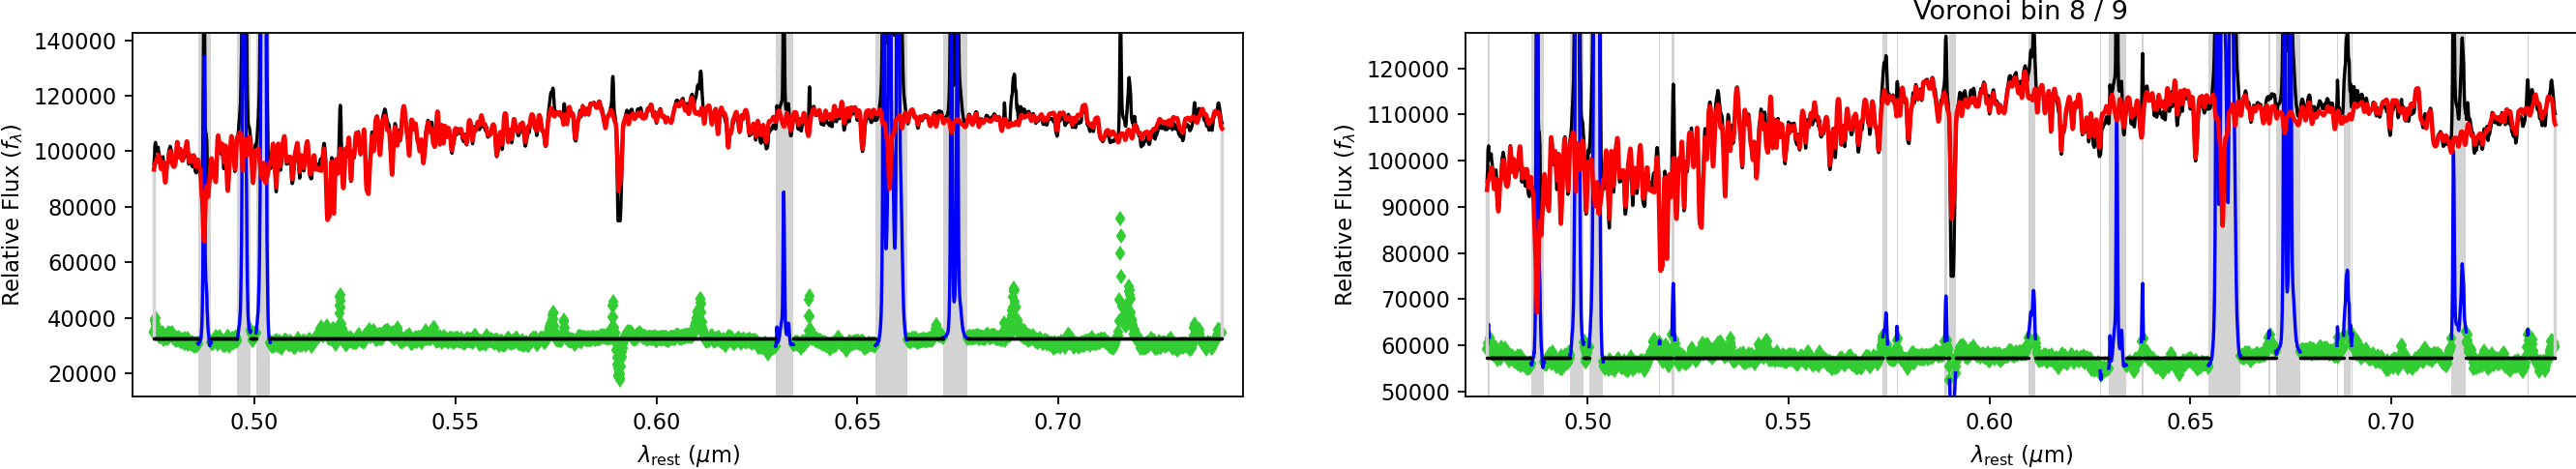

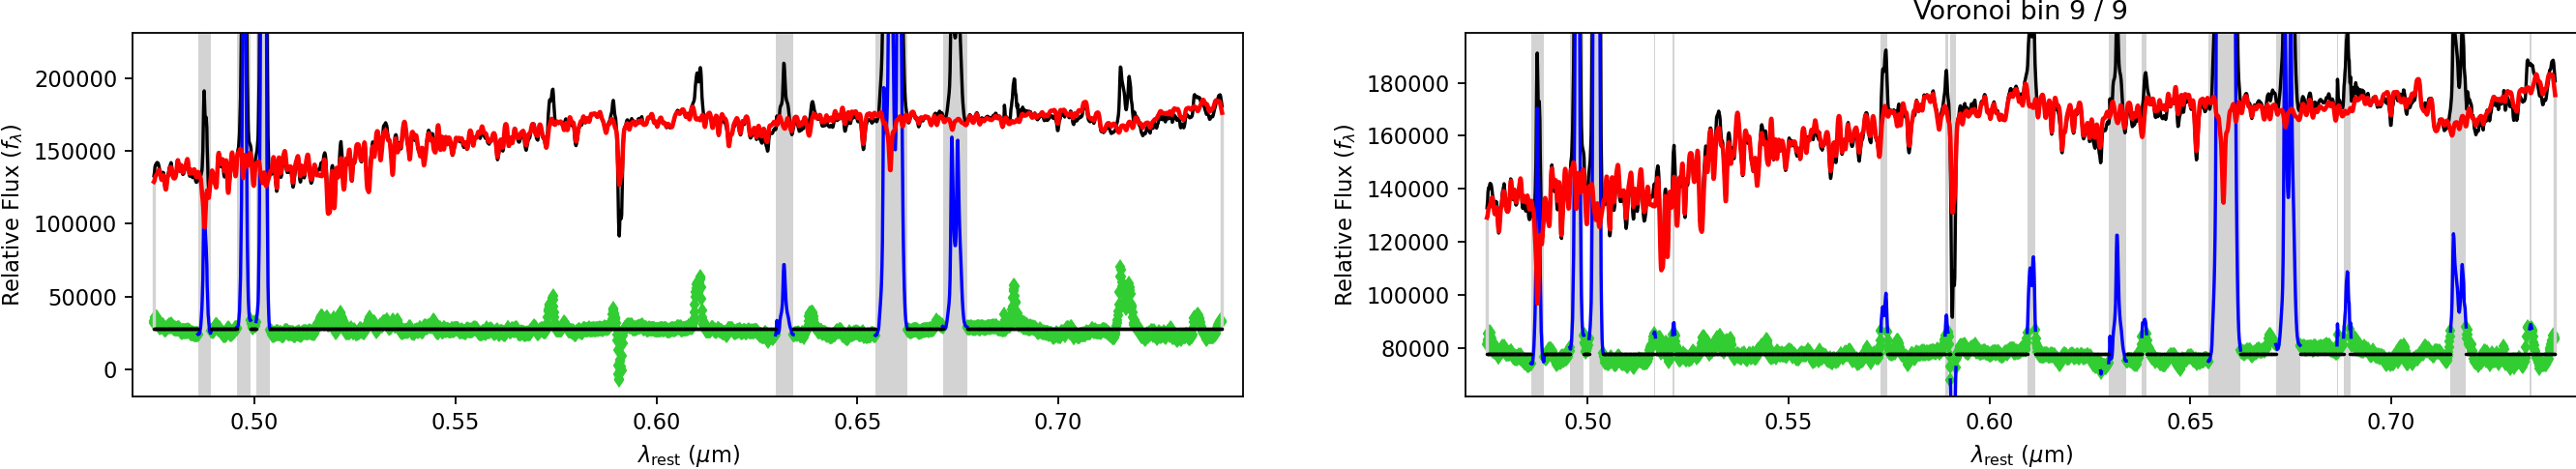

In [114]:
lam_gal = np.exp(s.ln_lam_gal)
for j in range(nbins):
    w = bin_num == j
    galaxy = np.sum(s.spectra[:, w], 1)
    pp, bestfit_template = fit_and_clean(stars_templates, galaxy, velscale, start, goodpixels0, lam_gal, sps.lam_temp)
    velbin[j], sigbin[j] = pp.sol
    optimal_templates[:, j] = bestfit_template

    light_weights = pp.weights.reshape(reg_dim)
    lg_age_bin[j], metalbin[j] = sps.mean_age_metal(light_weights)

    print(f'Voronoi bin: {j + 1} / {nbins}')
    plt.title(f"Voronoi bin {j + 1} / {nbins}")

Plot a map of the stellar velocity and lgAge in the Voronoi binned data.
This is the nearest neighbour interpolation. With very few bins, the maps are unreadable.

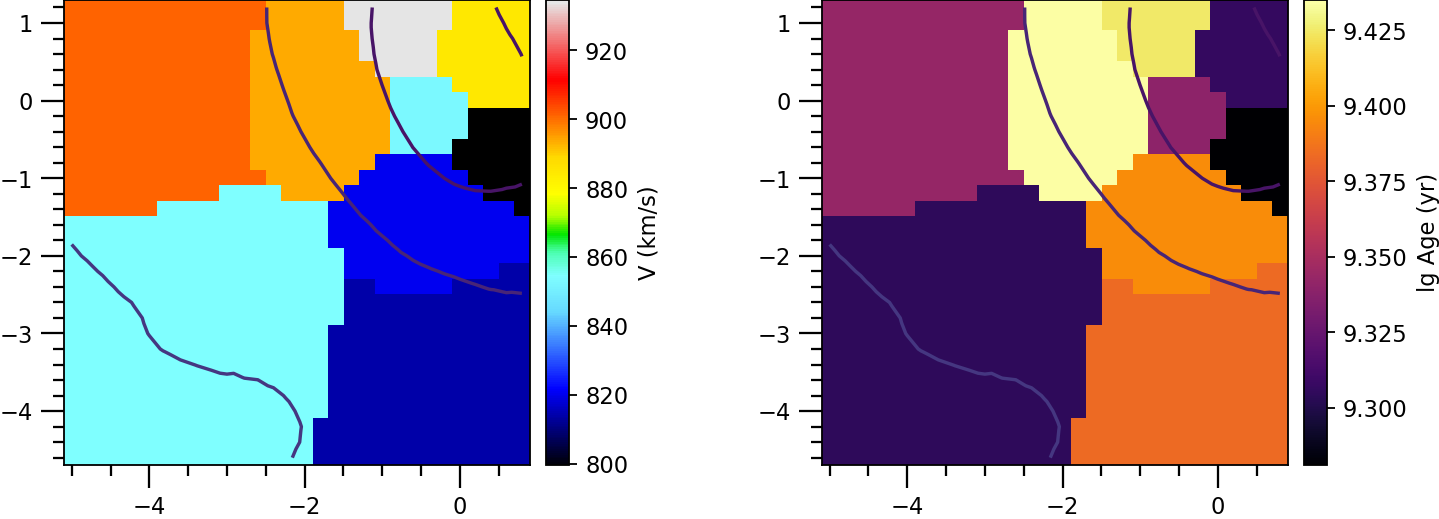

In [115]:
plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)

plt.subplot(121)
display_bins(s.x, s.y, bin_num, velbin, colorbar=1, label='V (km/s)')
plt.tricontour(s.x, s.y, -2.5*np.log10(signal/np.max(signal).ravel()), levels=np.arange(20));  # 1 mag contours

plt.subplot(122)
display_bins(s.x, s.y, bin_num, lg_age_bin, colorbar=1, cmap='inferno', label='lg Age (yr)')
plt.tricontour(s.x, s.y, -2.5*np.log10(signal/np.max(signal).ravel()), levels=np.arange(20));  # 1 mag contours

Here is the result of this Notebook when using a proper Voronoi binning with `target_sn=60`<br>
![](vel_age_maps.jpg)

## Setup the gas emission line templates

Construct a set of Gaussian emission line templates. They have the width of the instrumental LSF.


In [116]:
lam_range_gal = [np.min(lam_gal), np.max(lam_gal)]
gas_templates, gas_names, line_wave = util.emission_lines(ln_lam_temp, lam_range_gal, s.fwhm_gal)

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' 'HeI5876' '[OIII]5007_d'
 '[OI]6300_d' '[NII]6583_d']


Create three sets of gas templates for each of the 7 emission lines which fall within the fitted wavelength range.
In this example I want three components for each emission line and I can just replicate the same gas templates three times.
Below I add an index `_0, _1, _2` to the strings of the original names of the emission lines.
In general, one could decide to add a second component only to certain lines (e.g. the Balmer series) and for this one would select for the secondary kinematic components just some of the templates of the first component.

In [117]:
ngas_comp = 3    # I use three gas kinematic components
gas_templates = np.tile(gas_templates, ngas_comp)
gas_names = np.asarray([a + f"_({p+1})" for p in range(ngas_comp) for a in gas_names])
line_wave = np.tile(line_wave, ngas_comp)

## Combine the stellar and gas templates

Here I select a single spaxel for this example. However, in a real analysys this would be replaced by a foor loop over every spaxel

In [118]:
j = 611  # clear double
j = 682  # near nucleus

In [119]:
galaxy = s.spectra[:, j]
noise = np.ones_like(galaxy)

Use as galaxy template the one determined at higher-S/N from the bin containing the current spaxel. I also keep the stellar kinematic fixed to the value determined from that bin.

In [120]:
k = bin_num[j]
template = optimal_templates[:, k]

The templates are made of a single stellar template, as fitted previously on the bin that contain the spaxel under consideration plus a set of gas emission lines.

In [121]:
stars_gas_templates = np.column_stack([template, gas_templates])

## Setup of pPXF input parameters

I fit the following 7 gas emission line templates, and I include three kinematic components for each emission line

$H\beta$, $H\alpha$, [SII]6716, [SII]6731, HeI5876, [OIII]5007d, [OI]6300d, [NII]6583d

I assign `component=0` to the stellar template, and I assign two kinematic components to all narrow lines `component=1` and `component=2`. I also include a broad kinematic for every line `component=3`.

NOTE: in Python `[0] + [1]*8 --> [0, 1, 1, 1, 1, 1, 1, 1, 1]`

In [122]:
component = [0] + [1]*8 + [2]*8 + [3]*8

With my setup, the gas components are all `components` larger than zero

In [123]:
gas_component=np.array(component) > 0

I do not fit the stellar kinematics `component=0` (I set a negative `moments=-2`) but use instead the previously fitted kinematic solution for the Voronoi bin that include the spaxel under analysis. I fit two `moments=2` (V, sigma) for all three gas components

In [124]:
moments = [-2, 2, 2, 2]

As an illustration, I set some constraints on the kinematics of some lines. In particular, I set the (gas) velocity dispersion of the kinematic `component=2` equal to that of `component=1`.
I also set the (gas) mean velocity of the broad `component=3` equal to the average of the velocities of the narrow gas `component=1` and `component=2`.
See the `pPXF` [documentation](https://pypi.org/project/ppxf/) of the `tie` keyword to understand the syntax.
In formulas:

$$\sigma_2=\sigma_1$$
$$V_3=\frac{V_1+V_2}{2}$$

In [125]:
# start = [[V0, sig0], [V1, sig1], [V2, sig2], [V3, sig3]]
ncomp = len(moments)
tied = [['', ''] for j in range(ncomp)]
tied[2][1] = 'p[3]'                 # sig2 = sig1
tied[3][0] = '(p[2] + p[4])/2'      # V3 = (V1 + V2)/2

I want to avoid degeneracy between the narrow and broad gas components. For this, I set the constraint that the velocity dispersion of the broad gas `component=3` must be at least `sig_diff=200` km/s larger than the dispersion of any of the narrow components.
In formulas, I want to have both:

$$\sigma_1 + \sigma_{\rm diff} < \sigma_3$$

$$\sigma_2 + \sigma_{\rm diff} < \sigma_3$$

Following standard practice in numerical optimization (e.g. [HERE](https://uk.mathworks.com/help/optim/ug/linear-constraints.html)), I express these two inequalities as linear constraints in matrix form as this leads to an efficient optimization algorithm, with guaranteed local convergence:

$$\mathbf{A}_{\rm ineq}\cdot \mathbf{p} < \mathbf{b}_{\rm ineq}.$$

In this example, the vector of nonlinear kinematic parameters is $\mathbf{p}=[V_0, \sigma_0, V_1, \sigma_1, V_2, \sigma_2, V_3, \sigma_3]$ (following the same order of the `start` parameter of `pPXF`) and I can write the above matrix equation explicitly as

$$
\begin{bmatrix}
0 & 0 & 0 & 1 & 0 & 0 & 0 & -1 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & -1 \\
\end{bmatrix}
\cdot
\begin{bmatrix}
V_0 \\
\sigma_0 \\
V_1 \\
\sigma_1\\
V_2 \\
\sigma_2 \\
V_3 \\
\sigma_3
\end{bmatrix}
<
\begin{bmatrix}
-\sigma_{\rm diff} \\
-\sigma_{\rm diff} \\
\end{bmatrix}.
$$

This translates into the following Python code

In [126]:
sig_diff = 200  # minimum dispersion difference in km/s
A_ineq = np.array([[0, 0, 0, 1, 0, 0, 0, -1],       # sigma2 - sigma4 < -sigma_diff
                   [0, 0, 0, 0, 0, 1, 0, -1]])      # sigma3 - sigma4 < -sigma_diff
b_ineq = np.array([-sig_diff, -sig_diff])/velscale  # velocities have to be expressed in pixels
constr_kinem = {"A_ineq": A_ineq, "b_ineq": b_ineq}

The stellar kinematics is generally a good enough estimate for the gas one. However, as I am using `global_search`, the values of the starting guess are not necessary and are ignored.
NOTE: the starting guess must be feasible, namely it must satisfy the linear constraints above.

In [127]:
start = [[velbin[k], sigbin[k]],     # The stellar component=0 is fixed and this starting value will remain unchanged
         [velbin[k], 50],            # My starting guess for the velocity of all gas components is the stellar velocity
         [velbin[k], 50],            # however, this starting guess is ignored when using `global_search=True`
         [velbin[k], 500]]           # The starting guess must be feasible, namely must satisfy the constraints

As I am using `global_search`, the `bounds` below are important because they define the region that is initially explored by the global optimizer.
I define the bounds for the gas emission lines based on the stellar velocity of the Voronoi bin containing the spaxel that I am fitting.

In [128]:
vlim = lambda x: velbin[k] + x*np.array([-100, 100])
bounds = [[vlim(2), [20, 300]],       # Bounds are ignored for the stellar component=0 which has fixed kinematic
          [vlim(2), [20, 100]],       # I force the narrow component=1 to lie +/-200 km/s from the stellar velocity
          [vlim(6), [20, 100]],       # I force the narrow component=2 to lie +/-600 km/s from the stellar velocity
          [vlim(2), [20, 1000]]]      # I force the broad component=3 to lie +/-200 km/s from the stellar velocity

## pPXF fit of the gas emission lines

Given that this spectrum contains multiple kinematic components well separated in velocity, the $\chi^2$ necessarily contain multiple minima. For this reason, I set the keyword `global_search=1`. This keyword should be used *only* when the problem has obvious multiple minima, as it is much slower and completely unnecessary in normal situations. The use of `global_search` is unnecessary for most galaxies, as clear multiple components are uncommon.

In [129]:
#%matplotlib widget
#%matplotlib inline

differential_evolution step 1: f(x)= 7.38451e+07
differential_evolution step 2: f(x)= 6.29724e+07
differential_evolution step 3: f(x)= 3.02331e+07
differential_evolution step 4: f(x)= 3.02331e+07
differential_evolution step 5: f(x)= 2.94026e+07
differential_evolution step 6: f(x)= 2.94026e+07
differential_evolution step 7: f(x)= 2.88903e+07
differential_evolution step 8: f(x)= 2.88105e+07
differential_evolution step 9: f(x)= 2.76332e+07
differential_evolution step 10: f(x)= 2.75052e+07
differential_evolution step 11: f(x)= 2.75052e+07
differential_evolution step 12: f(x)= 2.74339e+07
 Best Fit:       Vel     sigma
 comp.  0:       854       112
 comp.  1:       804        83
 comp.  2:      1168        83
 comp.  3:       986       318
chi2/DOF: 1.037e+04; DOF: 2631; degree = 8; mdegree = 0
Global search - Func calls: 677
method = capfit; Jac calls: 2; Func calls: 12; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 21/25
Tied parameters:
 p[5] = p[3]
 p[6] = (p[2] + p[4])

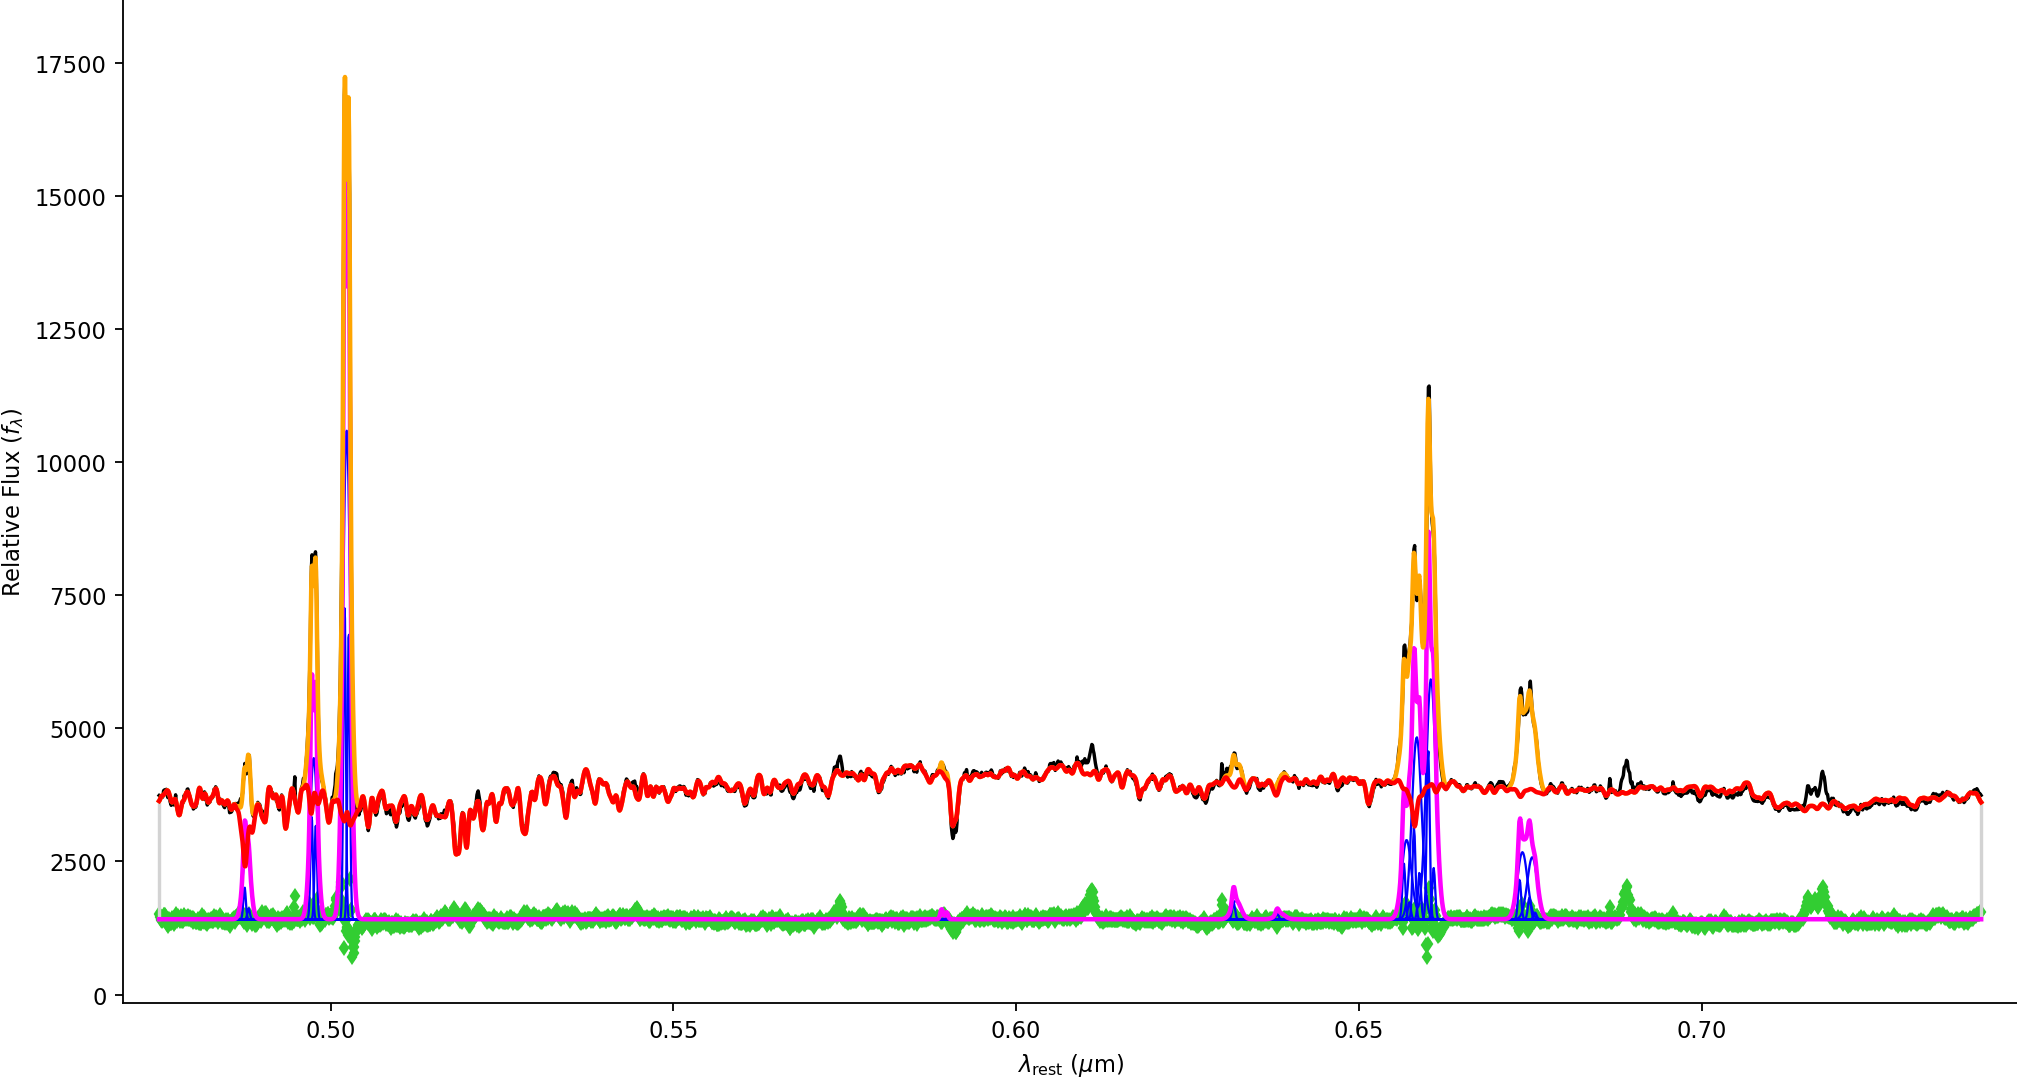

In [130]:
plt.figure(figsize=(15,8))
pp = ppxf(stars_gas_templates, galaxy, noise, velscale, start,
          plot=1, moments=moments, degree=8, mdegree=-1, component=component, 
          gas_component=gas_component, gas_names=gas_names, constr_kinem=constr_kinem,
          lam=lam_gal, lam_temp=sps.lam_temp, tied=tied, bounds=bounds, global_search=True)

Zoom into the two main emission lines. Overplot for reference the wavelength of the main emission lines at the recession velocity measured from the stellar kinematics.
This figure is nearly the same as Fig.2 of [Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C) except for the fact that here I also use the `tied` keyword. To reproduce the figure in the paper, set ``tied = None`` before the ``pPXF`` fit.

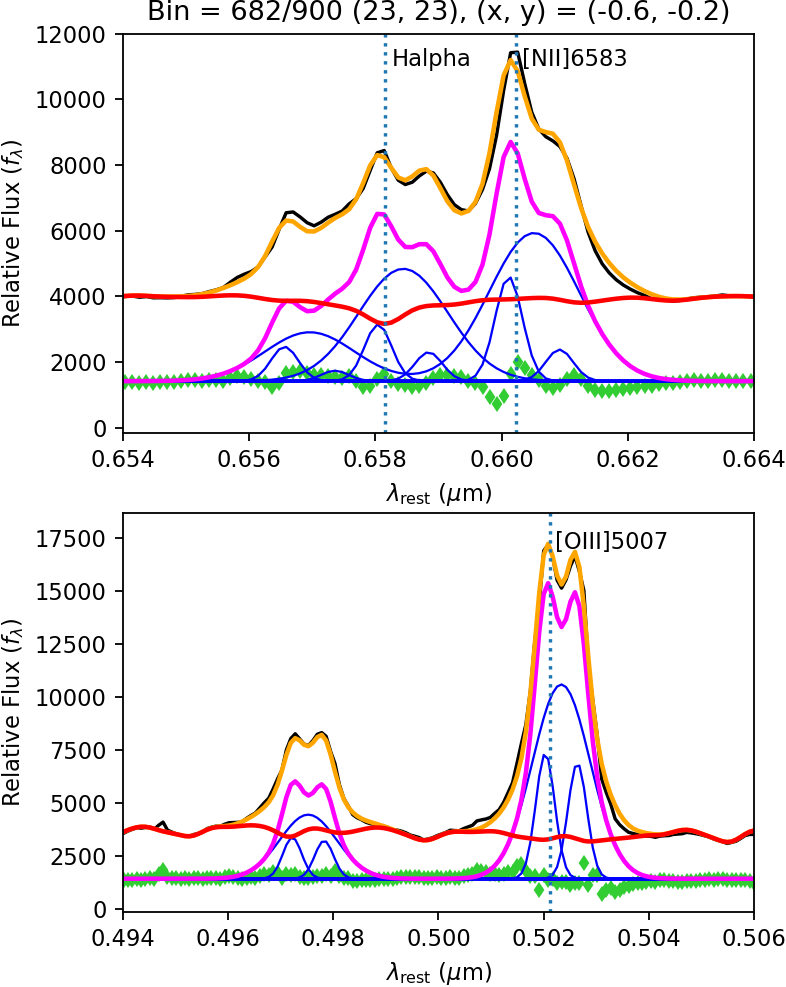

In [131]:
w = ['(1)' in c for c in gas_names]  # select first gas kinematic component
fig = plt.figure(figsize=(5,7))

plt.subplot(211)
plt.title(f"Bin = {j}/{s.col.size} ({s.col[j]}, {s.row[j]}), (x, y) = ({s.x[j]:.1f}, {s.y[j]:.1f})")
pp.plot()
lam_range = [0.654, 0.664]
vel_stars = pp.sol[0][0]   # stars velocity = 0th elements of 0th kinematic component 
for lam, nam in zip(line_wave[w], gas_names[w]):
    lam_rest = lam*np.exp(vel_stars/c_kms)/1e4
    if lam_range[0] < lam_rest < lam_range[1]:
        plt.axvline(lam_rest, ls=':')
        plt.text(lam_rest+1e-4, 11e3, nam[:nam.find('_')])
plt.xlim(lam_range)
plt.ylim([None, 12e3])

plt.subplot(212)
pp.plot()
lam_range = [0.494, 0.506]
for lam, nam in zip(line_wave[w], gas_names[w]):
    lam_rest = lam*np.exp(vel_stars/c_kms)/1e4
    if lam_range[0] < lam_rest < lam_range[1]:
        plt.axvline(lam_rest, ls=':')
        plt.text(lam_rest+1e-4, 17e3, nam[:nam.find('_')])
plt.xlim(lam_range);


The `pPXF` documentation [HERE](https://pypi.org/project/ppxf/#output-parameters) states:

>IMPORTANT: ``pPXF`` makes no assumptions about the input flux units: The returned ``.gas_flux`` has the same units and values one would measure (with lower accuracy) by summing the pixels values, within the given gas lines, on the continuum-subtracted input galaxy spectrum. This implies that, if the spectrum is in units of ``erg/(s cm^2 A)``, the ``.gas_flux`` returned by ``pPXF`` should be multiplied by the pixel size in Angstrom at the line wavelength to obtain the integrated line flux in units of ``erg/(s cm^2)``.

For this reason, below I multiply the flux returned by `pPXF` by the pixel size at the wavelength of each line.


In [132]:
rms = robust_sigma(galaxy - pp.bestfit, zero=1)

names = ['Halpha', 'Hbeta' , '[NII]6583_d', '[OIII]5007_d']
for p, name in enumerate(names):
    kk = gas_names == name + '_(1)'   # Extract first gas kinematic component
    dlam = line_wave[kk]*velscale/c_kms   # Angstrom per pixel at line wavelength (dlam/lam = dv/c)
    flux = (pp.gas_flux[kk]*dlam)[0]  # Convert to ergs/(cm^2 s)
    an = np.max(pp.gas_bestfit_templates[:, kk])/rms
    print(f"{name:12s} - Amplitude/Noise: {an:6.4g}; gas flux: {flux:6.0f} ergs/(cm^2 s)")

Halpha       - Amplitude/Noise:  25.15; gas flux:   9329 ergs/(cm^2 s)
Hbeta        - Amplitude/Noise:  8.647; gas flux:   2672 ergs/(cm^2 s)
[NII]6583_d  - Amplitude/Noise:  46.07; gas flux:  22942 ergs/(cm^2 s)
[OIII]5007_d - Amplitude/Noise:  85.42; gas flux:  35485 ergs/(cm^2 s)
